In [1]:
import cv2
import numpy as np
import scipy.ndimage as sn
from PIL import ImageEnhance, Image

def ObtainForegroundMask(image_path):
    """
    This function takes an image path as input, processes the image, 
    and returns the foreground mask using thresholding, morphological operations, and other filters.
    
    :param image_path: str, path to the input image
    :return: foreground mask (numpy array)
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst = Image.fromarray(dst)
    contrast = ImageEnhance.Contrast(dst)
    dst = contrast.enhance(1.5)
    dst = np.asarray(dst)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Thresholding and morphological operations
    _, mask = cv2.threshold(dst2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel)
    mask = sn.binary_fill_holes(mask).astype('uint8')
    kernel = np.ones((9, 9), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((11, 11), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask


In [2]:
import copy
from skimage.feature import peak_local_max

def FindCellLocations(image_path, foreground_mask):
    """
    This function takes the RGB image path and the foreground mask, 
    and returns the approximate cell locations using a distance transform approach.
    
    :param image_path: str, path to the input image
    :param foreground_mask: numpy array, the foreground mask
    :return: list of coordinates representing cell locations
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Apply thresholding to isolate foreground regions
    for row in range(dst2.shape[0]):
        for index in range(dst2.shape[1]):
            dst2[row][index] = 255 if dst2[row][index] > 195 else 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(dst2, kernel)
    new = copy.deepcopy(foreground_mask)

    # Remove foreground regions outside the eroded mask
    for row in range(dst2.shape[0]):
        for index in range(dst2.shape[1]):
            if erosion[row][index] == 255:
                new[row][index] = 0

    dist = cv2.distanceTransform(new, cv2.DIST_L2, 3)
    cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    coordinates = peak_local_max(dist, min_distance=14)

    return coordinates


In [3]:
import copy
import cv2

def neighbors(coor, cell):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    
    :param coor: tuple, coordinates of the cell
    :param cell: int, the cell identifier
    :return: list of neighboring cells
    """
    neighbor = [[cell, int(coor[0]), int(coor[1])]]
    for c in range(-1, 2):
        for d in range(-1, 2):
            neighbor.append([cell, int(coor[0]) + c * 3, int(coor[1]) + d * 3])
    return neighbor

def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask and cell locations.
    
    :param image_path: str, path to the input image
    :param foreground_mask: numpy array, the foreground mask
    :param cell_locations: list, coordinates of cell locations
    :return: segmented image with cells labeled
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Prepare region growing
    part_3 = copy.deepcopy(foreground_mask).astype(int)
    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == 1:
                part_3[row][index] = -1

    regions = []
    checked = []

    part_3 = np.pad(part_3, ((3, 3), (3, 3)), 'constant')

    for cell_id in range(len(cell_locations)):
        regions.extend(neighbors(cell_locations[cell_id], cell_id + 1))

    while regions:
        e = regions[0][0]
        x = regions[0][1]
        y = regions[0][2]
        checked.append(regions[0])
        
        if part_3[x + 3][y + 3] == -1:
            for c in range(-2, 3):
                for d in range(-2, 3):
                    part_3[x + c + 3][y + d + 3] = e
            neighs = neighbors([x, y], e)
            for e in neighs:
                if e not in checked:
                    regions.append(e)
        
        regions.pop(0)

    part_3 = part_3[3:-3, 3:-3]

    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == -1:
                part_3[row][index] = 0

    return part_3


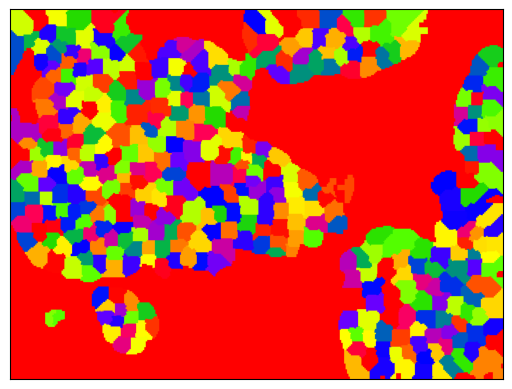

In [ ]:
import matplotlib.pyplot as plt


# Load data files
data_mask = np.loadtxt("im3_gold_mask.txt")
data_coor = np.loadtxt("im3_gold_cells.txt")

# Part 1: Obtain Foreground Mask
foreground_mask = ObtainForegroundMask('im3.jpg')

# Part 2: Find Cell Locations
cell_locations = FindCellLocations('im3.jpg', foreground_mask)

# Part 3: Find Cell Boundaries
segmentation_map = FindCellBoundaries('im3.jpg', foreground_mask, cell_locations)


# Visualize segmentation result
plt.imshow(segmentation_map, cmap='prism')
plt.xticks([]), plt.yticks([])
plt.show()


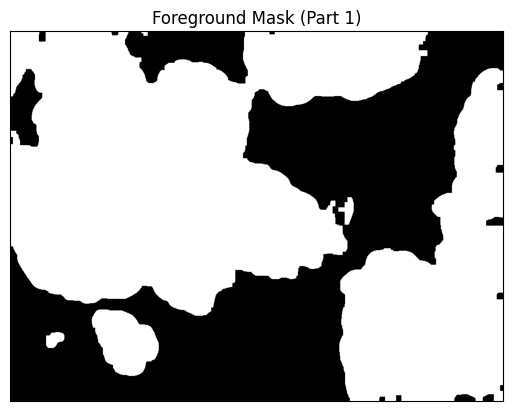

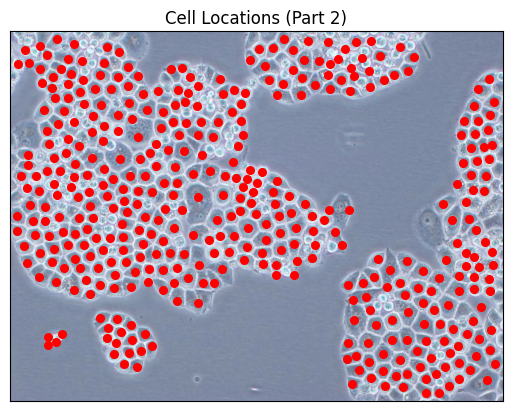

In [ ]:
import cv2
import numpy as np
import scipy.ndimage as sn
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
import copy
from skimage.feature import peak_local_max

# Part 1: ObtainForegroundMask function
def ObtainForegroundMask(image_path):
    """
    This function takes an image path as input, processes the image, 
    and returns the foreground mask using thresholding, morphological operations, and other filters.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst = Image.fromarray(dst)
    contrast = ImageEnhance.Contrast(dst)
    dst = contrast.enhance(1.5)
    dst = np.asarray(dst)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Thresholding and morphological operations
    _, mask = cv2.threshold(dst2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel)
    mask = sn.binary_fill_holes(mask).astype('uint8')
    kernel = np.ones((9, 9), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((11, 11), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# Part 2: FindCellLocations function
def FindCellLocations(image_path, foreground_mask):
    """
    This function takes the RGB image path and the foreground mask, 
    and returns the approximate cell locations using a distance transform approach.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Apply thresholding to isolate foreground regions
    dst2[dst2 > 195] = 255
    dst2[dst2 <= 195] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(dst2, kernel)
    new = copy.deepcopy(foreground_mask)

    # Remove foreground regions outside the eroded mask
    new[erosion == 255] = 0

    dist = cv2.distanceTransform(new, cv2.DIST_L2, 3)
    cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    coordinates = peak_local_max(dist, min_distance=14)

    return coordinates

# Part 3: FindCellBoundaries function
def neighbors(coor, cell):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    """
    neighbor = [[cell, int(coor[0]), int(coor[1])]]
    for c in range(-1, 2):
        for d in range(-1, 2):
            neighbor.append([cell, int(coor[0]) + c * 3, int(coor[1]) + d * 3])
    return neighbor

def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask and cell locations.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Prepare region growing
    part_3 = copy.deepcopy(foreground_mask).astype(int)
    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == 1:
                part_3[row][index] = -1

    regions = []
    checked = []

    part_3 = np.pad(part_3, ((3, 3), (3, 3)), 'constant')

    for cell_id in range(len(cell_locations)):
        regions.extend(neighbors(cell_locations[cell_id], cell_id + 1))

    while regions:
        e = regions[0][0]
        x = regions[0][1]
        y = regions[0][2]
        checked.append(regions[0])
        
        if part_3[x + 3][y + 3] == -1:
            for c in range(-2, 3):
                for d in range(-2, 3):
                    part_3[x + c + 3][y + d + 3] = e
            neighs = neighbors([x, y], e)
            for e in neighs:
                if e not in checked:
                    regions.append(e)
        
        regions.pop(0)

    part_3 = part_3[3:-3, 3:-3]

    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == -1:
                part_3[row][index] = 0

    return part_3

# Load data files
data_mask = np.loadtxt("im3_gold_mask.txt")
data_coor = np.loadtxt("im3_gold_cells.txt")

# Part 1: Obtain Foreground Mask
foreground_mask = ObtainForegroundMask('im3.jpg')

# Plot Part 1: Foreground Mask
plt.imshow(foreground_mask, cmap='gray')
plt.title("Foreground Mask (Part 1)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()

# Part 2: Find Cell Locations
cell_locations = FindCellLocations('im3.jpg', foreground_mask)

# Plot Part 2: Cell Locations
img = cv2.imread('im3.jpg')
plt.imshow(img)
plt.scatter(cell_locations[:, 1], cell_locations[:, 0], c='r', marker='o', s=30)
plt.title("Cell Locations (Part 2)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()

# Part 3: Find Cell Boundaries
segmentation_map = FindCellBoundaries('im3.jpg', foreground_mask, cell_locations)

# Plot Part 3: Segmentation Map
plt.imshow(segmentation_map, cmap='prism')
plt.title("Segmentation Map (Part 3)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()


In [ ]:
import cv2
import numpy as np
import scipy.ndimage as sn
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
import copy
from skimage.feature import peak_local_max

# Part 1: ObtainForegroundMask function
def ObtainForegroundMask(image_path):
    """
    This function takes an image path as input, processes the image, 
    and returns the foreground mask using thresholding, morphological operations, and other filters.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst = Image.fromarray(dst)
    contrast = ImageEnhance.Contrast(dst)
    dst = contrast.enhance(1.5)
    dst = np.asarray(dst)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Thresholding and morphological operations
    _, mask = cv2.threshold(dst2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(mask, kernel)
    mask = sn.binary_fill_holes(mask).astype('uint8')
    kernel = np.ones((9, 9), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((11, 11), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# Part 2: FindCellLocations function
def FindCellLocations(image_path, foreground_mask):
    """
    This function takes the RGB image path and the foreground mask, 
    and returns the approximate cell locations using a distance transform approach.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Apply thresholding to isolate foreground regions
    dst2[dst2 > 195] = 255
    dst2[dst2 <= 195] = 0

    kernel = np.ones((3, 3), np.uint8)
    erosion = cv2.erode(dst2, kernel)
    new = copy.deepcopy(foreground_mask)

    # Remove foreground regions outside the eroded mask
    new[erosion == 255] = 0

    dist = cv2.distanceTransform(new, cv2.DIST_L2, 3)
    cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    coordinates = peak_local_max(dist, min_distance=14)

    return coordinates

# Part 3: FindCellBoundaries function
def neighbors(coor, cell):
    """
    This function returns the neighboring pixels for a given cell location during region growing.
    """
    neighbor = [[cell, int(coor[0]), int(coor[1])]]
    for c in range(-1, 2):
        for d in range(-1, 2):
            neighbor.append([cell, int(coor[0]) + c * 3, int(coor[1]) + d * 3])
    return neighbor

def FindCellBoundaries(image_path, foreground_mask, cell_locations):
    """
    This function performs region growing to segment cells in the image using foreground mask and cell locations.
    """
    img = cv2.imread(image_path, 2)
    dst = cv2.fastNlMeansDenoising(img, None, 3, 7, 21)
    dst2 = cv2.GaussianBlur(dst, (3, 3), 0)

    # Prepare region growing
    part_3 = copy.deepcopy(foreground_mask).astype(int)
    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == 1:
                part_3[row][index] = -1

    regions = []
    checked = []

    part_3 = np.pad(part_3, ((3, 3), (3, 3)), 'constant')

    for cell_id in range(len(cell_locations)):
        regions.extend(neighbors(cell_locations[cell_id], cell_id + 1))

    while regions:
        e = regions[0][0]
        x = regions[0][1]
        y = regions[0][2]
        checked.append(regions[0])
        
        if part_3[x + 3][y + 3] == -1:
            for c in range(-2, 3):
                for d in range(-2, 3):
                    part_3[x + c + 3][y + d + 3] = e
            neighs = neighbors([x, y], e)
            for e in neighs:
                if e not in checked:
                    regions.append(e)
        
        regions.pop(0)

    part_3 = part_3[3:-3, 3:-3]

    for row in range(part_3.shape[0]):
        for index in range(part_3.shape[1]):
            if part_3[row][index] == -1:
                part_3[row][index] = 0

    return part_3

# Load data files
data_mask = np.loadtxt("im3_gold_mask.txt")
data_coor = np.loadtxt("im3_gold_cells.txt")

# Part 1: Obtain Foreground Mask
foreground_mask = ObtainForegroundMask('im3.jpg')

# Metrics for Part 1: Foreground Mask
TP = np.sum((foreground_mask == 1) & (data_mask == 1))
FP = np.sum((foreground_mask == 1) & (data_mask == 0))
FN = np.sum((foreground_mask == 0) & (data_mask == 1))

prec = TP / (TP + FP)
recall = TP / (TP + FN)
Fscore = TP / (TP + (1/2 *(FP + FN)))

print('Part 1 Metrics:')
print("Precision: {:.2f}".format(prec))
print("Recall: {:.2f}".format(recall))
print("Fscore: {:.2f}".format(Fscore))

# Plot Part 1: Foreground Mask
plt.imshow(foreground_mask, cmap='gray')
plt.title("Foreground Mask (Part 1)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()

# Part 2: Find Cell Locations
cell_locations = FindCellLocations('im3.jpg', foreground_mask)

# Metrics for Part 2: Cell Locations
TP_2 = 0
cells = []
for x, y in cell_locations:
    cells = np.append(cells, data_coor[int(x)][int(y)])

# Count True Positives (TP), False Positives (FP), and duplicates in cells
val = 999
dup = 0
for c in range(cells.size):
    if val != cells[c] and cells[c] != 0:
        TP_2 += 1
        dup = 0
    if val == cells[c] and cells[c] != 0:
        dup = 1
    val = cells[c]
TP_2 -= dup

prec_2 = TP_2 / cells.size
recall_2 = TP_2 / data_coor.max()
Fscore_2 = (2 * prec_2 * recall_2) / (prec_2 + recall_2)

print('\nPart 2 Metrics:')
print("Precision: {:.2f}".format(prec_2))
print("Recall: {:.2f}".format(recall_2))
print("Fscore: {:.2f}".format(Fscore_2))

# Plot Part 2: Cell Locations
img = cv2.imread('im3.jpg')
plt.imshow(img)
plt.scatter(cell_locations[:, 1], cell_locations[:, 0], c='r', marker='o', s=30)
plt.title("Cell Locations (Part 2)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()

# Part 3: Find Cell Boundaries
segmentation_map = FindCellBoundaries('im3.jpg', foreground_mask, cell_locations)

# Metrics for Part 3: Dice and IoU
TP_3 = 0
FP_3 = 0
FN_3 = 0
for row in range(segmentation_map.shape[0]):
    for index in range(segmentation_map.shape[1]):
        if segmentation_map[row][index] == 1 and data_mask[row][index] == 1:
            TP_3 += 1
        if segmentation_map[row][index] == 1 and data_mask[row][index] == 0:
            FP_3 += 1
        if segmentation_map[row][index] == 0 and data_mask[row][index] == 1:
            FN_3 += 1

Dice = 2 * TP_3 / (2 * TP_3 + FP_3 + FN_3)
IoU = TP_3 / (TP_3 + FP_3 + FN_3)

print('\nPart 3 Metrics:')
print("Dice: {:.2f}".format(Dice))
print("IoU: {:.2f}".format(IoU))

# Plot Part 3: Segmentation Map
plt.imshow(segmentation_map, cmap='prism')
plt.title("Segmentation Map (Part 3)")
plt.xticks([]), plt.yticks([])  # Hide ticks
plt.show()
